In [1]:
import tensorflow as tf
import numpy as np
import math, os, random
from matplotlib import pyplot as plt
from scipy import misc as misc

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [4]:
def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.
  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.
  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob

In [5]:
# Create the model
x = tf.placeholder(tf.float32, [None, 28, 28, 1])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(80000):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    # Random shift
    batch_xs = np.pad(np.reshape(batch_xs, [-1, 28, 28, 1]), [(0, 0), (6, 6), (6, 6), (0, 0)], mode='constant')
    y_shift = random.randint(0, 12)
    x_shift = random.randint(0, 12)
    batch_xs = batch_xs[:, x_shift:x_shift+28, y_shift:y_shift+28, :]
    if i % 1000 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys, 
                                                       keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
print('test accuracy %g' % sess.run(accuracy, feed_dict={x: np.reshape(mnist.test.images, [-1, 28, 28, 1]), y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.1
step 1000, training accuracy 0.8
step 2000, training accuracy 0.92
step 3000, training accuracy 0.96
step 4000, training accuracy 0.94
step 5000, training accuracy 0.98
step 6000, training accuracy 0.98
step 7000, training accuracy 0.96
step 8000, training accuracy 1
step 9000, training accuracy 0.98
step 10000, training accuracy 0.96
step 11000, training accuracy 0.96
step 12000, training accuracy 0.96
step 13000, training accuracy 0.98
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 0.98
step 17000, training accuracy 1
step 18000, training accuracy 0.96
step 19000, training accuracy 0.98
step 20000, training accuracy 0.96
step 21000, training accuracy 0.96
step 22000, training accuracy 1
step 23000, training accuracy 0.96
step 24000, training accuracy 0.98
step 25000, training accuracy 1
step 26000, training accuracy 1
step 27000, training accuracy 0.98
step 28000, training accuracy 1
step 29000, training acc

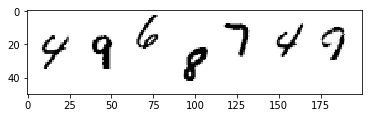

In [6]:
canvas = np.zeros(shape=(50, 200))
num_digits = 7
digits, labels = mnist.train.next_batch(num_digits)
digits = np.reshape(digits, [num_digits, 28, 28, 1])

for i in range(num_digits):
    y_shift = random.randint(0, 20)
    x_shift = random.randint(0, 3)
    canvas[y_shift:28+y_shift, x_shift+i*28:x_shift+i*28+28] = digits[i, :, :, 0]

plt.imshow(canvas, cmap='Greys')
plt.show()

In [7]:
bx = np.zeros(shape=(4*34, 28, 28))
for i in range(4):
    for j in range(34):
        # print(i, j, canvas[i*5:i*5+28, j*5:j*5+28].shape)
        bx[i*34+j, :, :] = canvas[i*5:i*5+28, j*5:j*5+28]
bx = np.reshape(bx, [-1, 28, 28, 1])

In [8]:
soft_max_y = tf.nn.softmax(y_conv)
pred = sess.run(soft_max_y, feed_dict={x: bx, keep_prob: 1.0})

In [9]:
result = np.zeros([4, 34, 10])
for i in range(4):
    for j in range(34):
        result[i, j] = pred[i*34+j]

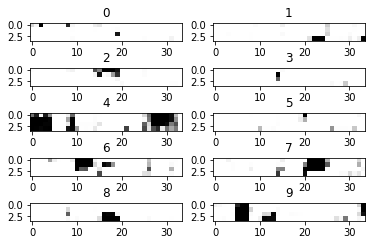

In [10]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.title('%d' % i)
    plt.imshow(result[:, :, i], cmap='Greys')
plt.show()

Iteration 1000, Negative log likelihood is 53.941055, elbo loss is 131.917679
Iteration 2000, Negative log likelihood is 57.332245, elbo loss is 40.535316


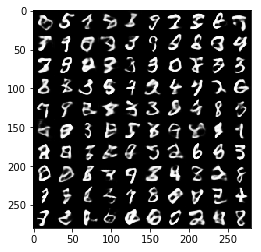

Iteration 3000, Negative log likelihood is 50.684044, elbo loss is 39.864990
Iteration 4000, Negative log likelihood is 54.011154, elbo loss is 39.617264


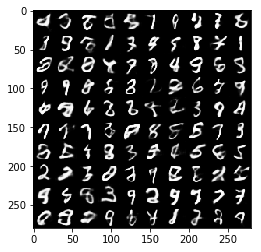

Iteration 5000, Negative log likelihood is 49.721565, elbo loss is 39.117432
Iteration 6000, Negative log likelihood is 49.762615, elbo loss is 39.869694


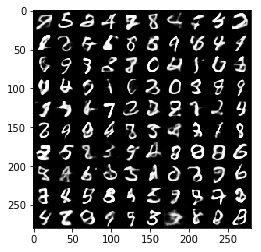

Iteration 7000, Negative log likelihood is 49.965744, elbo loss is 39.479790
Iteration 8000, Negative log likelihood is 46.856552, elbo loss is 40.231693


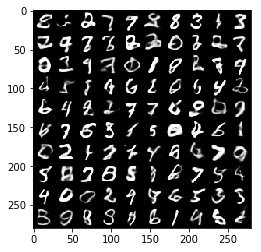

Iteration 9000, Negative log likelihood is 47.305641, elbo loss is 38.898132
Iteration 10000, Negative log likelihood is 42.645615, elbo loss is 37.974701


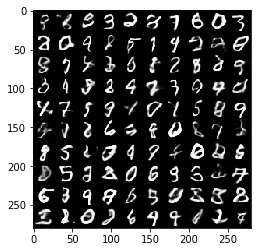

Iteration 11000, Negative log likelihood is 41.809006, elbo loss is 37.385757
Iteration 12000, Negative log likelihood is 44.089180, elbo loss is 36.757767


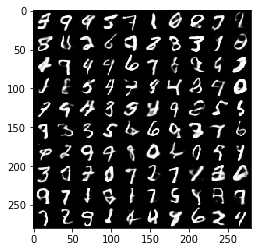

Iteration 13000, Negative log likelihood is 42.887890, elbo loss is 38.031769
Iteration 14000, Negative log likelihood is 38.373318, elbo loss is 37.898998


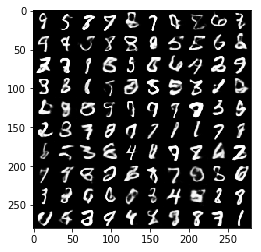

Iteration 15000, Negative log likelihood is 40.643639, elbo loss is 37.917126
Iteration 16000, Negative log likelihood is 43.343891, elbo loss is 38.538826


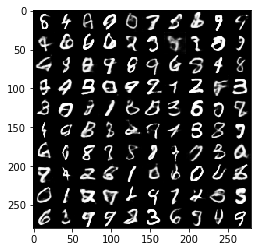

Iteration 17000, Negative log likelihood is 42.455990, elbo loss is 38.593018
Iteration 18000, Negative log likelihood is 37.482773, elbo loss is 36.613117


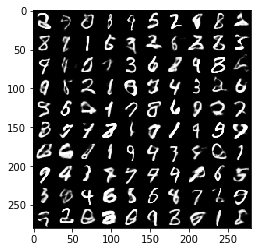

Iteration 19000, Negative log likelihood is 39.910053, elbo loss is 39.540005
Iteration 20000, Negative log likelihood is 40.953743, elbo loss is 38.350101


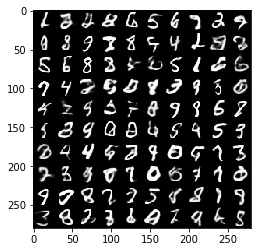

Iteration 21000, Negative log likelihood is 38.485161, elbo loss is 37.570492
Iteration 22000, Negative log likelihood is 38.033943, elbo loss is 37.817310


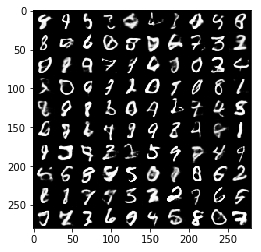

Iteration 23000, Negative log likelihood is 37.886387, elbo loss is 37.449703
Iteration 24000, Negative log likelihood is 40.029453, elbo loss is 39.440823


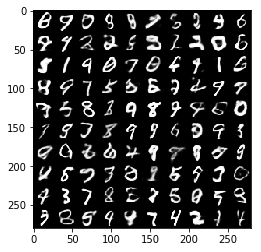

Iteration 25000, Negative log likelihood is 37.763733, elbo loss is 38.138222
Iteration 26000, Negative log likelihood is 36.791443, elbo loss is 37.824986


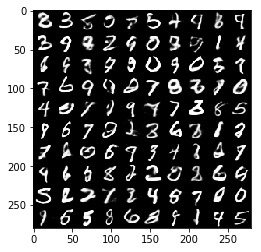

Iteration 27000, Negative log likelihood is 36.734119, elbo loss is 38.549770
Iteration 28000, Negative log likelihood is 36.778461, elbo loss is 38.043770


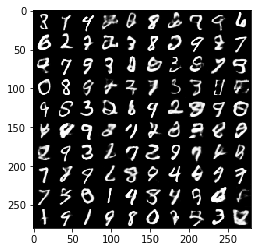

Iteration 29000, Negative log likelihood is 37.113304, elbo loss is 38.594643
Iteration 30000, Negative log likelihood is 36.158787, elbo loss is 37.303013


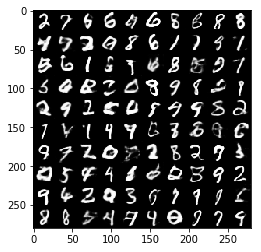

Iteration 31000, Negative log likelihood is 36.135113, elbo loss is 37.412117
Iteration 32000, Negative log likelihood is 35.023140, elbo loss is 36.977039


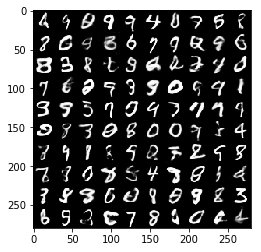

Iteration 33000, Negative log likelihood is 36.036209, elbo loss is 38.004784
Iteration 34000, Negative log likelihood is 36.404625, elbo loss is 38.538277


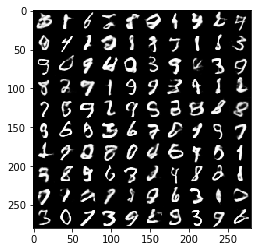

Iteration 35000, Negative log likelihood is 33.805542, elbo loss is 35.897919
Iteration 36000, Negative log likelihood is 31.795662, elbo loss is 37.831848


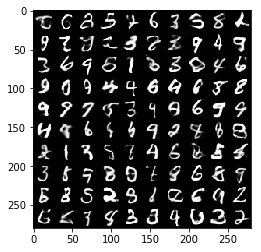

Iteration 37000, Negative log likelihood is 35.190067, elbo loss is 37.774002
Iteration 38000, Negative log likelihood is 32.564713, elbo loss is 36.945034


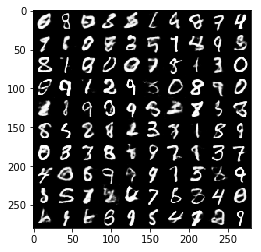

Iteration 39000, Negative log likelihood is 34.499023, elbo loss is 37.733486
Iteration 40000, Negative log likelihood is 33.375870, elbo loss is 37.126102


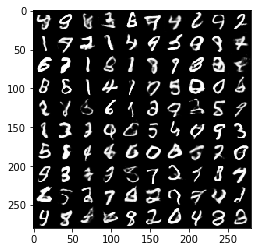

Iteration 41000, Negative log likelihood is 33.777809, elbo loss is 37.592091
Iteration 42000, Negative log likelihood is 34.254036, elbo loss is 36.338943


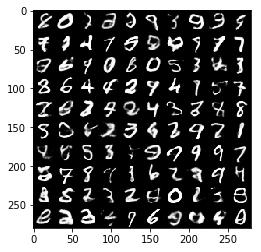

Iteration 43000, Negative log likelihood is 33.847771, elbo loss is 37.418907
Iteration 44000, Negative log likelihood is 33.594433, elbo loss is 38.332932


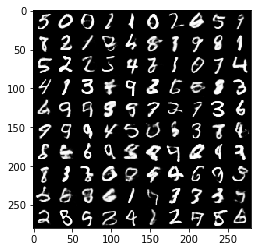

Iteration 45000, Negative log likelihood is 31.987305, elbo loss is 39.083755
Iteration 46000, Negative log likelihood is 32.694679, elbo loss is 37.958733


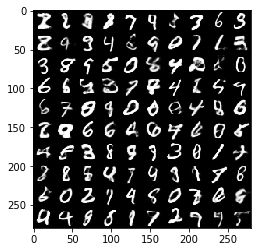

Iteration 47000, Negative log likelihood is 32.679825, elbo loss is 37.370697
Iteration 48000, Negative log likelihood is 33.791721, elbo loss is 37.211399


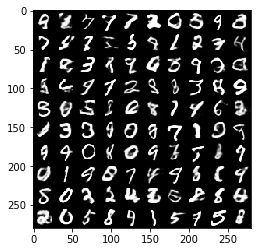

Iteration 49000, Negative log likelihood is 33.840458, elbo loss is 37.091133
Iteration 50000, Negative log likelihood is 36.865528, elbo loss is 39.414894


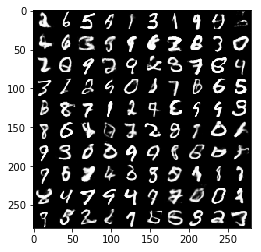

Iteration 51000, Negative log likelihood is 32.753483, elbo loss is 37.291679
Iteration 52000, Negative log likelihood is 33.467377, elbo loss is 37.911736


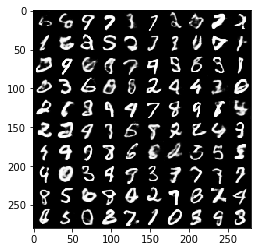

Iteration 53000, Negative log likelihood is 30.673246, elbo loss is 37.154861
Iteration 54000, Negative log likelihood is 31.908905, elbo loss is 35.907436


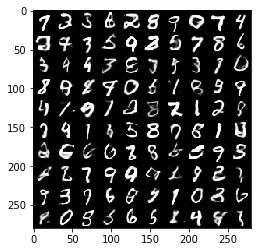

Iteration 55000, Negative log likelihood is 32.945770, elbo loss is 38.083488
Iteration 56000, Negative log likelihood is 34.422249, elbo loss is 38.755676


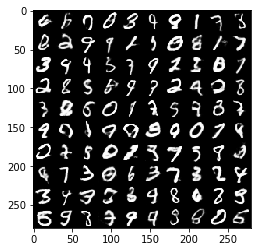

Iteration 57000, Negative log likelihood is 31.605154, elbo loss is 37.598835
Iteration 58000, Negative log likelihood is 30.264374, elbo loss is 36.510571


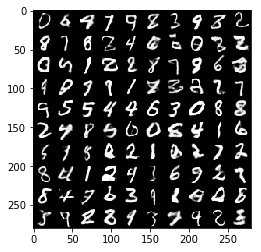

Iteration 59000, Negative log likelihood is 30.991661, elbo loss is 36.513153
Iteration 60000, Negative log likelihood is 31.947403, elbo loss is 37.649048


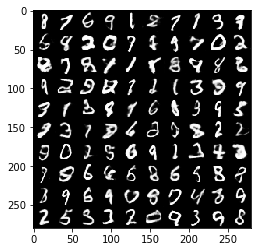

Iteration 61000, Negative log likelihood is 31.711637, elbo loss is 36.223255
Iteration 62000, Negative log likelihood is 31.774010, elbo loss is 36.734924


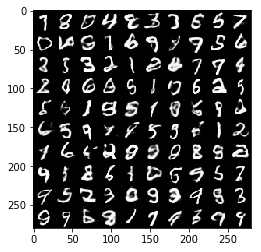

Iteration 63000, Negative log likelihood is 29.542358, elbo loss is 36.483795
Iteration 64000, Negative log likelihood is 30.260523, elbo loss is 37.493279


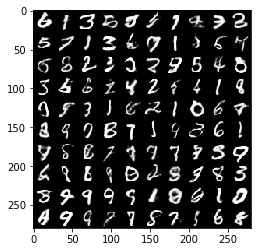

Iteration 65000, Negative log likelihood is 30.959345, elbo loss is 36.713837
Iteration 66000, Negative log likelihood is 30.941311, elbo loss is 37.406887


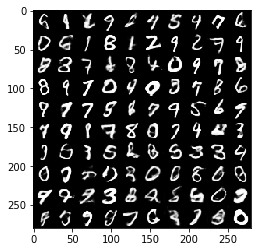

Iteration 67000, Negative log likelihood is 32.327457, elbo loss is 38.008778
Iteration 68000, Negative log likelihood is 32.072201, elbo loss is 37.539223


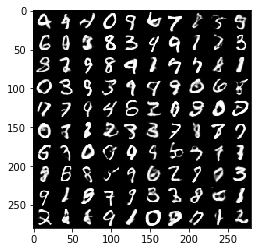

Iteration 69000, Negative log likelihood is 32.090515, elbo loss is 37.652210
Iteration 70000, Negative log likelihood is 33.463848, elbo loss is 39.181690


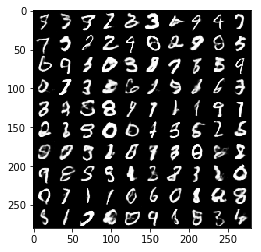

Iteration 71000, Negative log likelihood is 30.769768, elbo loss is 36.764431
Iteration 72000, Negative log likelihood is 30.111687, elbo loss is 37.676727


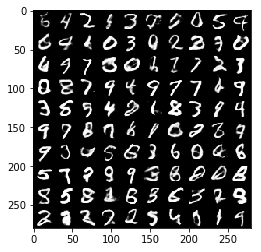

Iteration 73000, Negative log likelihood is 29.918327, elbo loss is 36.048512
Iteration 74000, Negative log likelihood is 29.808914, elbo loss is 36.511848


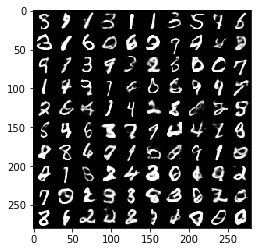

Iteration 75000, Negative log likelihood is 29.438244, elbo loss is 36.504498
Iteration 76000, Negative log likelihood is 30.325432, elbo loss is 37.551830


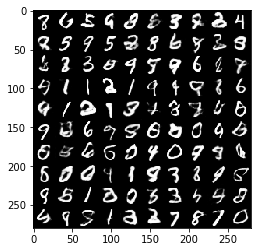

Iteration 77000, Negative log likelihood is 31.098642, elbo loss is 37.745834
Iteration 78000, Negative log likelihood is 29.955633, elbo loss is 37.387711


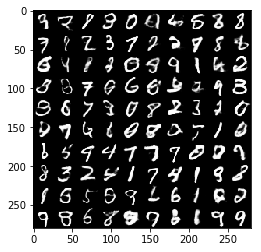

Iteration 79000, Negative log likelihood is 28.750191, elbo loss is 37.584866


In [11]:
# Define some handy network layers
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

# Encoder and decoder use the DC-GAN architecture
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)   # None x 14 x 14 x 64
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)   # None x 7 x 7 x 128
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])]) # None x (7x7x128)
        fc1 = fc_lrelu(conv2, 1024)
        mean = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)
        stddev = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.sigmoid)
        stddev = tf.maximum(stddev, 0.005)
        return mean, stddev

def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        output = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        return output

# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

# Build the computation graph for training
z_dim = 20
train_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
train_zmean, train_zstddev = encoder(train_x, z_dim)
train_z = train_zmean + tf.multiply(train_zstddev,
                                    tf.random_normal(tf.stack([tf.shape(train_x)[0], z_dim])))
train_xr = decoder(train_z)
loss_nll_per_sample = tf.reduce_sum(tf.square(train_xr - train_x), axis=[1, 2, 3]) * 10
loss_nll = tf.reduce_mean(loss_nll_per_sample)
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x = decoder(gen_z, reuse=True)

# ELBO loss divided by input dimensions
loss_elbo_per_sample = tf.reduce_sum(-tf.log(train_zstddev) + 0.5 * tf.square(train_zstddev) +
                                     0.5 * tf.square(train_zmean) - 0.5, axis=1)
loss_elbo = tf.reduce_mean(loss_elbo_per_sample)

loss_per_sample = loss_nll_per_sample + loss_elbo_per_sample
elbo_anneal = tf.placeholder(tf.float32)
loss = loss_nll + loss_elbo * elbo_anneal

with tf.variable_scope('trainer2'):
    trainer = tf.train.AdamOptimizer(1e-3).minimize(loss)

sess_ll = tf.Session()
sess_ll.run(tf.global_variables_initializer())

# Start training
batch_size = 100
for i in range(1, 80000):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    batch_xs = np.pad(np.reshape(batch_xs, [-1, 28, 28, 1]), [(0, 0), (3, 3), (3, 3), (0, 0)], mode='constant')
    y_shift = random.randint(0, 6)
    x_shift = random.randint(0, 6)
    batch_xs = batch_xs[:, x_shift:x_shift+28, y_shift:y_shift+28, :]
    if i < 1000:
        elbo_val = 0.01
    else:
        elbo_val = 1.0
    _, nll, elbo = sess_ll.run([trainer, loss_nll, loss_elbo], feed_dict={train_x: batch_x, elbo_anneal: elbo_val})
    if i % 1000 == 0:
        print("Iteration %d, Negative log likelihood is %f, elbo loss is %f" % (i, nll, elbo))
    if i % 2000 == 0:
        samples = sess_ll.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()

In [12]:
def estimate_prob(images):
    pred_ll = sess_ll.run(loss_per_sample, feed_dict={train_x: bx})
    result_ll = np.zeros([4, 34])
    for i in range(4):
        for j in range(34):
            result_ll[i, j] = pred_ll[i*34+j]
    return result_ll

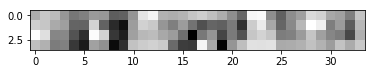

In [13]:
result_prob = estimate_prob(bx)
plt.imshow(result_prob, cmap='Greys')
plt.show()

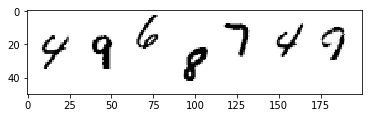

In [14]:
plt.imshow(canvas, cmap='Greys')
plt.show()

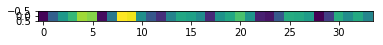

In [15]:
max_prob = []
for i, argmin in enumerate(np.argmin(result_prob, axis=0)):
    max_prob.append(result_prob[argmin, i])
max_prob = np.array(max_prob)

plt.imshow(np.reshape(max_prob, [1, 34]))
plt.show()

In [16]:
digits = []
for i in range(7):
    location_x = int(math.floor(i * 28.0 / 5.0))
    location_y = np.argmax(result_prob[:, location_x])
    print(np.argmax(result[location_y, location_x, :]))

4
9
6
8
7
4
9
